In [36]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import itertools

from matplotlib import pyplot as plt
from datetime import datetime

import tensorflow as tf
import torch
import sklearn
import keras

import networkx as nx

In [37]:
# Original data sets are located at:
# https://www.kaggle.com/datasets/chadgostopp/recsys-challenge-2015
# I will use yoochoose-buys.dat and yoochoose-test.dat to test graph creation and GCN ML build-test pipeline
#
# The raw data and jupyter notebook can be found at: C:/Users/c1twc/P_CCB
# To upload to Github, you need to copy/paste jupyter notebook to OneDrive location:
# Ta-Wei - Personal/Documents/GitHub/ZTA

consumer = pd.read_csv("yoochoose-buys.csv")

In [38]:
consumer['date'] = pd.to_datetime(consumer['timeStamp']).dt.date
consumer['time'] = pd.to_datetime(consumer['timeStamp']).dt.time 

In [39]:
# Pre-processing
# Split the raw timeStamp, e.g. 2014-04-06T18:44:58.314Z, into two new columns: 'date' and 'time'
consumer['date'] = pd.to_datetime(consumer['timeStamp']).dt.date
consumer['time'] = pd.to_datetime(consumer['timeStamp']).dt.time 

# Pre-processing
# Split the 'date' column into 3 new columns: 'year', 'month', and 'day'
consumer['year'] = pd.to_datetime(consumer['date']).dt.year
consumer['month'] = pd.to_datetime(consumer['date']).dt.month
consumer['day'] = pd.to_datetime(consumer['date']).dt.day

# Since the original 'time' column contains data that are datetime.time object, not datetime.date.datetime object,
# you need to first convert all the objects from 'datetime.time' to 'datetime.datetime' type, 
# then perform dt.hour, dt.minute, and d.second operations
# 
consumer['time'] = pd.to_datetime(consumer['time'].apply(lambda x: x.strftime('%H:%M:%S')))
consumer['hour'] = consumer['time'].dt.hour
consumer['minute'] = consumer['time'].dt.minute
consumer['second'] = consumer['time'].dt.second

consumer['day_of_week'] = pd.to_datetime(consumer['date']).dt.day_name()

In [40]:
consumer.head()

,sessionId,timeStamp,itemId,price,quantity,date,time,year,month,day,hour,minute,second,day_of_week
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1,2014-04-06,2023-04-15 18:44:58,2014,4,6,18,44,58,Sunday
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1,2014-04-06,2023-04-15 18:44:58,2014,4,6,18,44,58,Sunday
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1,2014-04-06,2023-04-15 09:40:13,2014,4,6,9,40,13,Sunday
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1,2014-04-04,2023-04-15 06:13:28,2014,4,4,6,13,28,Friday
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1,2014-04-04,2023-04-15 06:13:28,2014,4,4,6,13,28,Friday


In [41]:
consumer_new = consumer.drop(['date', 'time'], axis=1)

In [42]:
consumer_new.head()

,sessionId,timeStamp,itemId,price,quantity,year,month,day,hour,minute,second,day_of_week
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1,2014,4,6,18,44,58,Sunday
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1,2014,4,6,18,44,58,Sunday
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1,2014,4,6,9,40,13,Sunday
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1,2014,4,4,6,13,28,Friday
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1,2014,4,4,6,13,28,Friday


In [43]:
consumer_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   sessionId    1048575 non-null  int64 
 1   timeStamp    1048575 non-null  object
 2   itemId       1048575 non-null  int64 
 3   price        1048575 non-null  int64 
 4   quantity     1048575 non-null  int64 
 5   year         1048575 non-null  int64 
 6   month        1048575 non-null  int64 
 7   day          1048575 non-null  int64 
 8   hour         1048575 non-null  int64 
 9   minute       1048575 non-null  int64 
 10  second       1048575 non-null  int64 
 11  day_of_week  1048575 non-null  object
dtypes: int64(10), object(2)
memory usage: 96.0+ MB


In [44]:
# Use a small subset of consumer_new for testing
#
consumer_new_small = consumer_new[0:4000]

G = nx.Graph()
num_nodes = consumer_new_small.shape[0]

# Create trasaction nodes -- each row, representing one specific action, is treated as a separated node
214761480
for i in range(num_nodes):
    G.add_node(i, sessionId=consumer_new['sessionId'][i],
              itemId=consumer_new['itemId'][i],
              price=consumer_new['price'][i],
              quantity=consumer_new['quantity'][i],
              year=consumer_new['year'][i],
              month=consumer_new['month'][i],
              day=consumer_new['day'][i],
              hour=consumer_new['hour'][i],
              minute=consumer_new['minute'][i],
              second=consumer_new['second'][i],
              day_of_week=consumer_new['day_of_week'][i])


In [45]:
# Create 'Item' node with attribute of 'itemId'
item = list(set(consumer_new['itemId']))

G_item = nx.Graph()

num_item_nodes = len(item)

for i in range(num_item_nodes):
    G_item.add_node(i, itemId=item[i], color='red')

In [46]:
for i in range(num_nodes):
    if G.nodes[i]['itemId'] in item:
        idx = item.index(G.nodes[i]['itemId'])
        G.add_edge(G.nodes[i]['sessionId'], G_item.nodes[idx]['itemId'])
#        print(G.nodes[i]['sessionId'], G_item.nodes[idx]['itemId'])

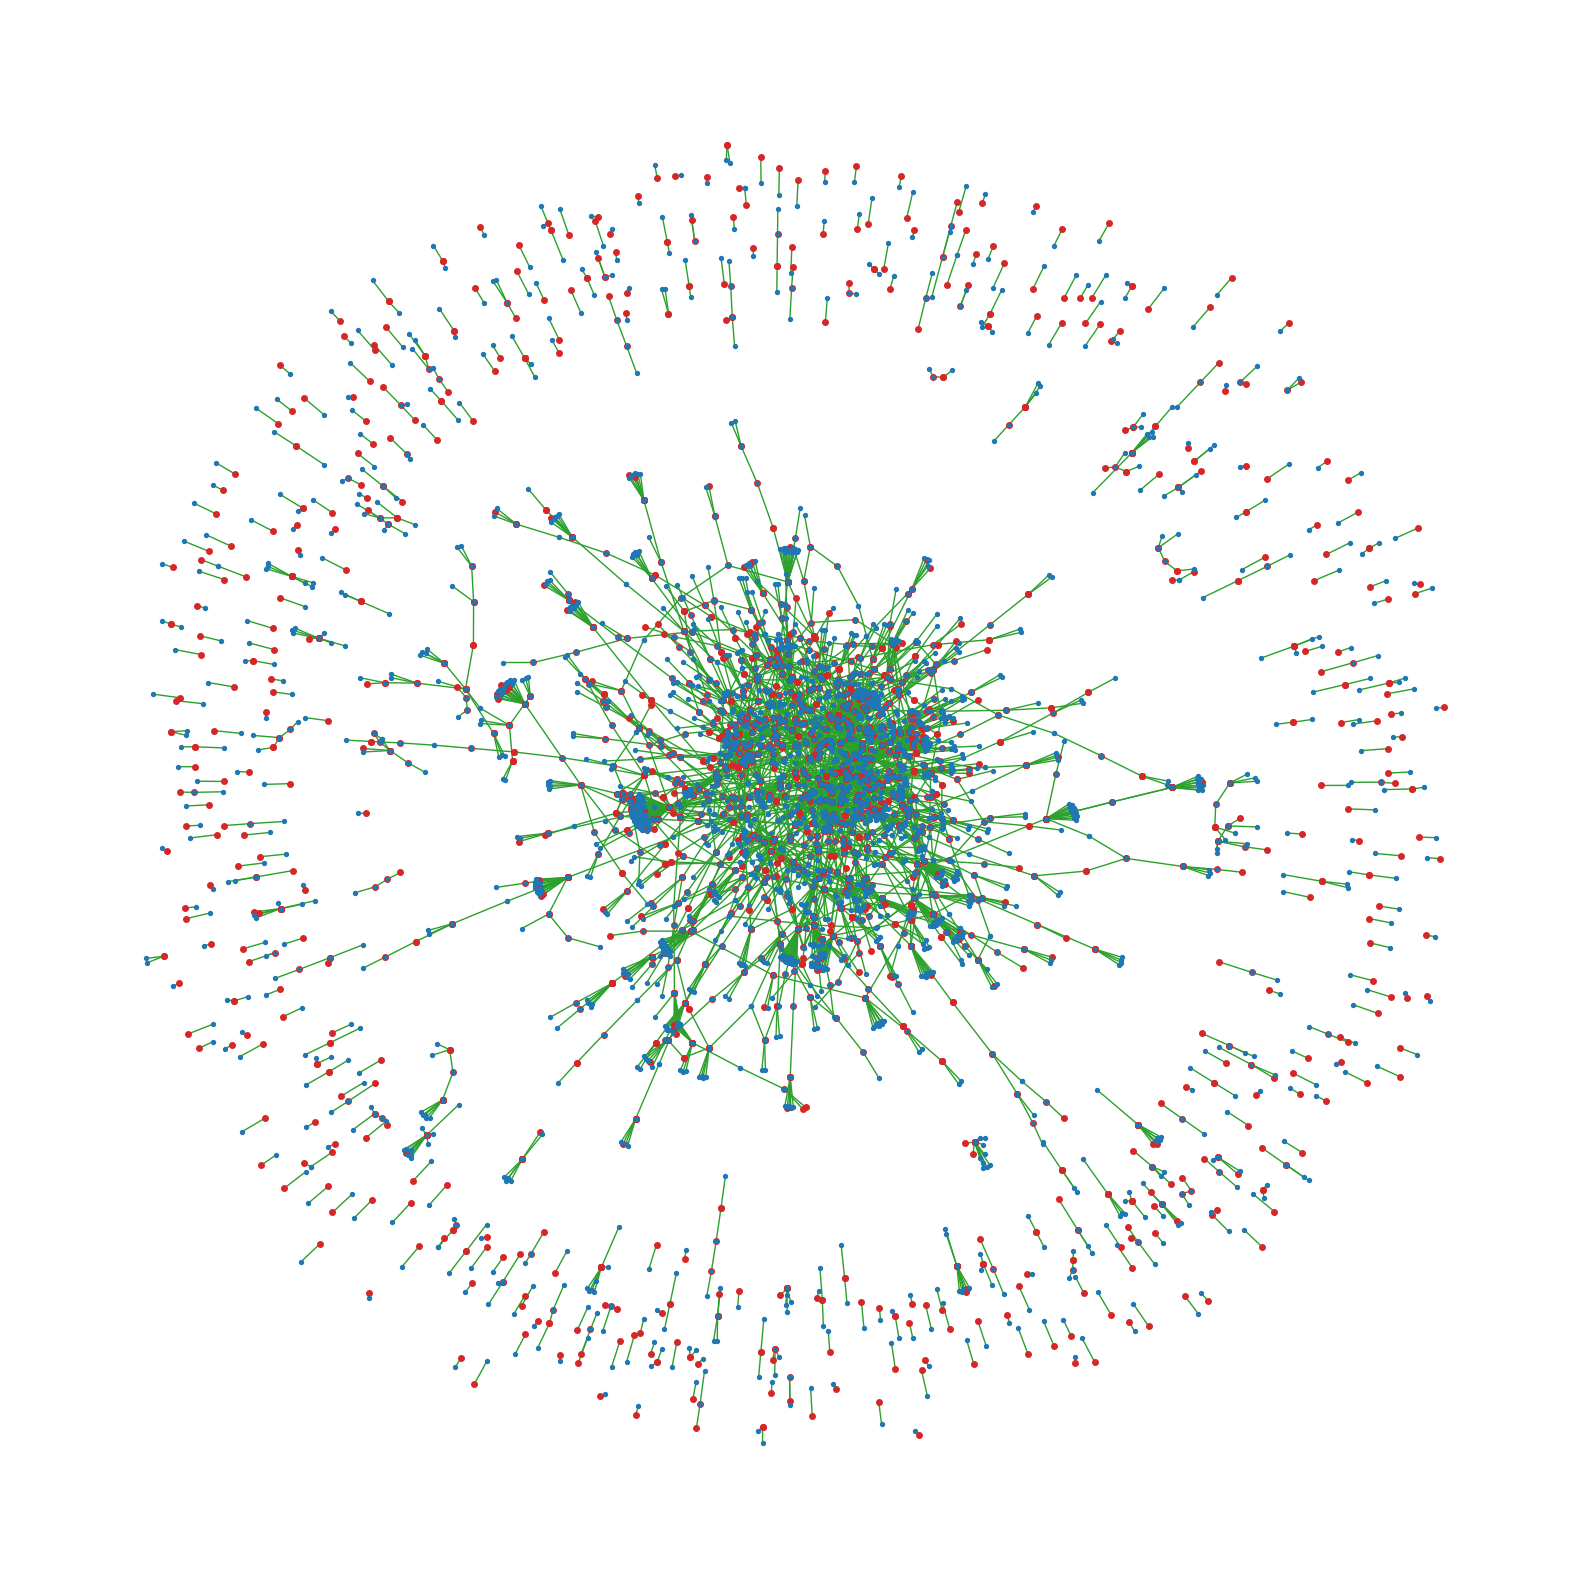

In [48]:
G_edge_lst = list(G.edges())

s_id_lst = [] 
i_id_lst = []
for e in G_edge_lst:
    s_id_lst.append(e[0])
    i_id_lst.append(e[1])

G_s = nx.Graph()
G_i = nx.Graph()
G_t = nx.Graph()

G_s.add_nodes_from(s_id_lst)
G_i.add_nodes_from(i_id_lst)
G_t.add_nodes_from([G_s, G_i])

#G_t.add_nodes_from(G_i)

G_t.add_edges_from(G_edge_lst)

pos = nx.spring_layout(G_t, k=0.025, seed = random.randint(1,10e7))
#pos = nx.fruchterman_reingold_layout(G_t)

nx.draw_networkx_nodes(G_t, pos, nodelist=s_id_lst, node_size=16, node_color="tab:red")
nx.draw_networkx_nodes(G_t, pos, nodelist=i_id_lst, node_size=8, node_color="tab:blue")
nx.draw_networkx_edges(G_t, pos, node_size=20, edge_color="tab:green")

plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.autolayout'] = True
plt.tight_layout()
plt.figure(1, figsize=(20,20))
plt.axis("off")
plt.show()